# Oakland Airport Database
## Week 6 Continued
### This week, I cleaned the Oakland Airport database and produced visualizations for the data, similar to the ones I created previously for SFO. I also emailed San Jose Airport inquiring about access to the data in XLSX/CSV format, and I am waiting to hear back.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from scipy.optimize import curve_fit
import math


import hashlib
%matplotlib inline
pd.set_option('mode.chained_assignment', None)


sns.set(style="dark")
# plt.style.use("ggplot")

In [2]:
flights = pd.read_excel("Airport Statistics 2010-2021.xlsx")
flights.head()

,Unnamed: 0,ENPLANING,DEPLANING,TOTAL,ANNUAL,Unnamed: 5,Unnamed: 6,PAX CARRIERS,CARGO CARRIERS,TOTAL.1,...,TOTAL TRIP COUNT,ANNUAL.9,TOTAL TNC REVENUES,ANNUAL.10,Unnamed: 63,TO BART (ENTRIES),ANNUAL.11,TO AIRPORT (EXITS),ANNUAL.12,TOTAL PASSENGERS
0,2021-12-15,414984,398282,813266,8142320.0,NaN,2021-12-15,465047.0,455803.0,920850.0,...,91857.0,847568.0,339870.9,3136001.6,NaN,15252,143891.0,14941,116225.0,30193.0
1,2021-11-15,412665,408995,821660,NaN,NaN,2021-11-15,464646.0,327704.0,792350.0,...,97373.0,NaN,360280.1,NaN,NaN,19012,NaN,16042,NaN,35054.0
2,2021-10-15,414522,411311,825833,NaN,NaN,2021-10-15,483319.0,321841.0,805160.0,...,95512.0,NaN,353394.4,NaN,NaN,18587,NaN,14534,NaN,33121.0
3,2021-09-15,383398,379181,762579,NaN,NaN,2021-09-15,471773.0,317088.0,788861.0,...,85546.0,NaN,316520.2,NaN,NaN,18283,NaN,14932,NaN,33215.0
4,2021-08-15,398160,416578,814738,NaN,NaN,2021-08-15,468768.0,319319.0,788087.0,...,84930.0,NaN,314241.0,NaN,NaN,16500,NaN,12551,NaN,29051.0


Note: To speed up the data cleaning process, I adjusted some things in the Excel file manually including spacing and columns.

## Data Cleaning

In [3]:
flights.rename(columns={"Unnamed: 0": "Dates", '    TOTAL': "Aircraft Movements"}, inplace=True)
for column in flights:
    if "Unnamed" in column:
        flights.drop(columns=[column], inplace=True)
    elif "TOTAL" in column:
        flights.drop(columns=[column], inplace=True)
    elif "ANNUAL" in column:
        flights.drop(columns=[column], inplace=True)
    elif "ROUNDED" in column:
        flights.drop(columns=[column], inplace=True)


flights = flights.loc[:, 'Dates':'FREIGHT OUT']  
flights.head()

,Dates,ENPLANING,DEPLANING,PAX CARRIERS,CARGO CARRIERS,Aircraft Movements,CONTRACT SALES,GENERAL AVATION,INBOUND AIRMAIL,OUTBOUND AIRMAIL,FREIGHT IN,FREIGHT OUT
0,2021-12-15,414984,398282,465047.0,455803.0,16603,9696723,965232.0,951845,878202,64477018,62160816
1,2021-11-15,412665,408995,464646.0,327704.0,16793,7926017,886550.7,805733,736099,52487411,52587414
2,2021-10-15,414522,411311,483319.0,321841.0,17025,8157640,998778.1,863853,733576,53289927,54307061
3,2021-09-15,383398,379181,471773.0,317088.0,16331,8274218,825998.8,750978,541371,52530945,54427354
4,2021-08-15,398160,416578,468768.0,319319.0,17250,8353831,875866.1,634694,392438,49991098,51831503


#### We will only take half of the "Aircraft Movements" into account because we are only considering the takeoffs. We may assume that every aircraft that lands at OAK also takes off from OAK, so there would be a 1:1 ratio between landings and takeoffs.

In [4]:
landings = flights[["Dates", "Aircraft Movements"]]
landings['Landing Count'] = round(landings["Aircraft Movements"] / 2)
landings['Landing Count'] = landings['Landing Count'].astype('int')
landings.drop(columns='Aircraft Movements', inplace=True)
monthly = landings.sort_values(by="Dates")
monthly.head()

,Dates,Landing Count
143,2010-01-15,9029
142,2010-02-15,8362
141,2010-03-15,9548
140,2010-04-15,9360
139,2010-05-15,9678


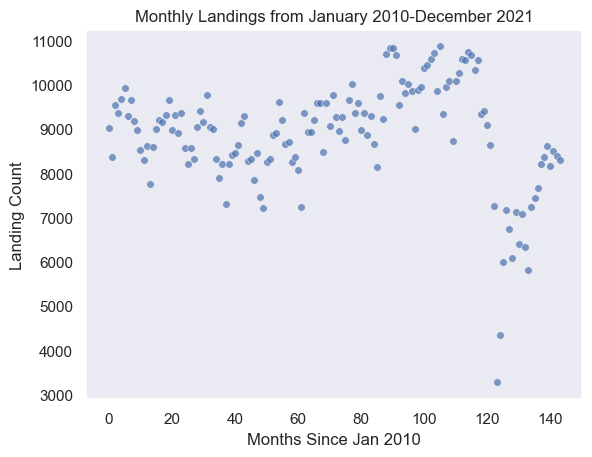

In [5]:
x_axis = np.arange(0, len(monthly), 1)
sns.scatterplot(data=monthly, x=x_axis, y='Landing Count', s=30, alpha = 0.7);
plt.title("Monthly Landings from January 2010-December 2021")
plt.xlabel("Months Since Jan 2010");

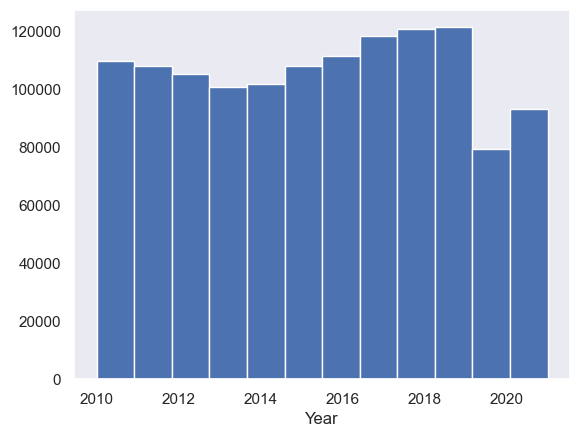

In [42]:
yearly = landings.loc[:, ["Dates", "Landing Count"]]
yearly["Year"] = pd.DatetimeIndex(landings['Dates']).year
yearly = yearly.drop(columns=["Dates"])
yearly = yearly.groupby("Year").sum()
yearly = yearly.reset_index()

plt.hist(yearly["Year"], bins=12, weights=yearly["Landing Count"])
# plt.title("Yearly Landings from 2010-2021")
plt.xlabel("Year");
# plt.ylabel("Number of Landings");

#### I removed 2020 and 2021 from the data because we are not considering post-COVID stats.

In [7]:
monthly = landings.loc[:, ["Dates", "Landing Count"]]
monthly["Month"] = pd.DatetimeIndex(monthly['Dates']).month
monthly["Year"] = pd.DatetimeIndex(monthly['Dates']).year
monthly = monthly.drop(columns=["Dates"])
monthly = monthly[monthly["Year"] < 2020]
monthly = monthly.groupby(["Year","Month"]).sum()
monthly = monthly.reset_index()

monthly_avg = monthly.groupby('Month').mean()
monthly_avg = monthly_avg.drop(columns=['Year'])
monthly_avg.rename(columns={'Landing Count': 'Average Landings'}, inplace=True)
monthly_avg.reset_index(inplace=True)
monthly_avg.head()

,Month,Average Landings
0,1,8782.5
1,2,8094.0
2,3,9151.7
3,4,9055.2
4,5,9551.9


#### Next, I got normalized the number of monthly landings by dividing the landings by the number of days per month

In [8]:
feb_avg = (11 * 28 + 3 * 29) / 14
days_per_month = {1: 31,
                  2: feb_avg,
                  3: 31, 
                  4: 30,
                  5: 31,
                  6: 30,
                  7: 31,
                  8: 30,
                  9: 31,
                  10: 31,
                  11: 30,
                  12: 31}

daily_avg = monthly_avg.copy()
daily_avg['Days Per Month'] = daily_avg['Month'].apply(lambda x: days_per_month[x])
daily_avg['Landings Per Day'] = daily_avg['Average Landings'] / daily_avg['Days Per Month']
daily_avg.head()

,Month,Average Landings,Days Per Month,Landings Per Day
0,1,8782.5,31.000000,283.306452
1,2,8094.0,28.214286,286.875949
2,3,9151.7,31.000000,295.216129
3,4,9055.2,30.000000,301.840000
4,5,9551.9,31.000000,308.125806


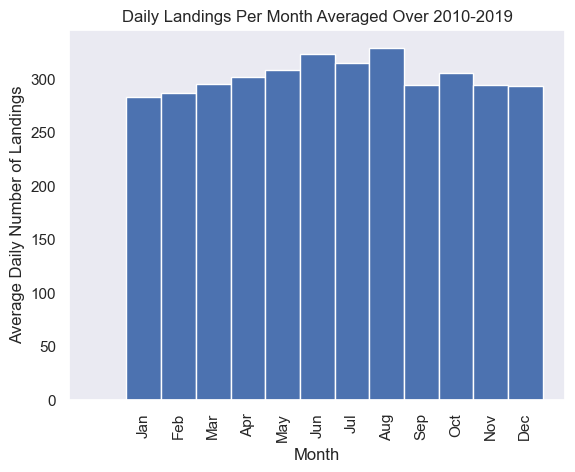

In [9]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.hist(daily_avg["Month"], bins=np.arange(14)-0.5, weights=daily_avg["Landings Per Day"])
plt.title("Daily Landings Per Month Averaged Over 2010-2019")
plt.xlabel("Month")
plt.xticks(daily_avg["Month"], months, rotation='vertical')
plt.ylabel("Average Daily Number of Landings");

## Then, I began working on the regression model.

In [10]:
daily_avg_across = monthly.copy()
daily_avg_across['Days Per Month'] = daily_avg_across['Month'].apply(lambda x: days_per_month[x])
daily_avg_across['Landings Per Day'] = daily_avg_across['Landing Count'] / daily_avg_across['Days Per Month']
daily_avg_across.head()

,Year,Month,Landing Count,Days Per Month,Landings Per Day
0,2010,1,9029,31.000000,291.258065
1,2010,2,8362,28.214286,296.374684
2,2010,3,9548,31.000000,308.000000
3,2010,4,9360,30.000000,312.000000
4,2010,5,9678,31.000000,312.193548


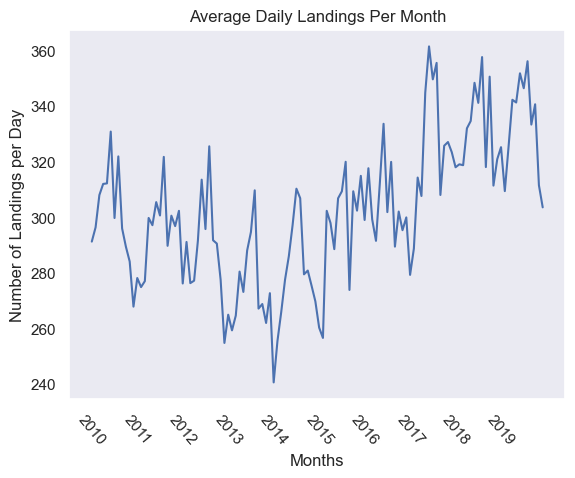

In [11]:
X = np.arange(0, len(daily_avg_across))
y = daily_avg_across['Landings Per Day'].tolist()
plt.plot(X, y)
x_ticks = np.arange(0, len(X), step=12)
x_labels = np.arange(2010, 2020)
plt.xticks(x_ticks, x_labels, rotation=310)
plt.title("Average Daily Landings Per Month")
plt.xlabel("Months")
plt.ylabel("Number of Landings per Day")
plt.show()

#### Here, we see that the data seems to be decreasing from 2010-2014, increasing from 2014-2017, and leveling off from 2017-2019. Therefore, we will use the data from 2017 on for the most accurate results.

### Week 6 Wrap Up
This week, I finished working on SFO and moved onto the Oakland Airport dataset. I spent some time cleaning the data manually on the Excel file along with regular Python data cleaning methods. I then used similar methods to SFO to create data visualizations for both monthly and annual trends.

## Week 7

### This week, I continued the regression model and projections from last week. Additionally, because this dataset does not have aircraft types, I spent a lot of time researching the most common aircraft types at Oakland Airport.

### I messed around with the start year a bit to see which year would fit the best.

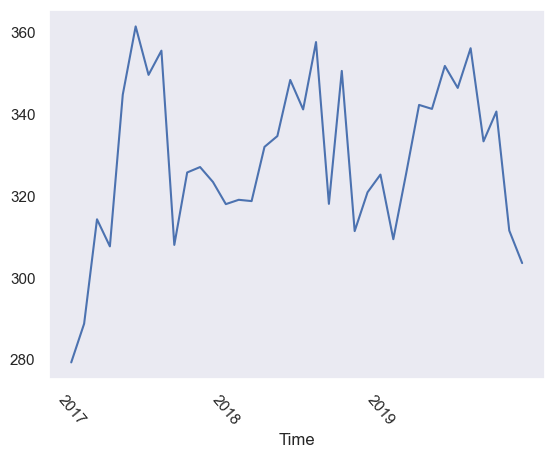

In [43]:
start_yr = 2017
daily_avg_bounded = daily_avg_across[daily_avg_across['Year'] >= start_yr].reset_index(drop=True)

# daily_avg_bounded = daily_avg_bounded.drop([0, 1])
# daily_avg_bounded.drop(daily_avg_bounded.tail(12).index,inplace=True)

X = np.arange(0, len(daily_avg_bounded))
y = daily_avg_bounded['Landings Per Day'].tolist()
plt.plot(X, y)
x_ticks = np.arange(0, len(X), step=12)
x_labels = np.arange(start_yr, 2020)
plt.xticks(x_ticks, x_labels, rotation=310)
# plt.title("Average Daily Landings Per Month")
plt.xlabel("Time")
# plt.ylabel("Landings per Day")
plt.show()

In [13]:
# average each month
X = np.arange(12)
y = [np.mean([y[i], y[i+12], y[i+24]]) for i in range(12)]

In [14]:
def sinusoid(x,A,offset,omega,phase):
    return A*np.sin(omega*x+phase) + offset

T = 12
def get_p0(x, y):
    A0 = (max(y[0:T]) - min(y[0:T]))/2
    offset0 = y[0]
    phase0 = 0
    omega0 = 2.0*np.pi/T
    return [A0, offset0, omega0, phase0]

#### Get the maximums and minimums of each year. Then, find the offset of the sine graph:

In [15]:
def get_peaks(y, metrics):
    n = int(math.ceil(len(y)/T))
    step = 0
    x_peaks = []
    y_peaks = []
    for i in np.arange(0, n):
        peak_index = y.index(metrics(y[step:step+T]))
        x_peaks.append(peak_index)
        y_peaks.append(y[peak_index])
        step = step+T
    return [x_peaks,y_peaks]

min_peaks = get_peaks(y,min)
max_peaks = get_peaks(y,max)

In [16]:
A = []
offset = []
for i in range(0, len(min_peaks[1])):
    c_a = (max_peaks[1][i] - min_peaks[1][i])/2
    c_offset = min_peaks[1][i] + c_a
    for j in range(0,T):
        A.append(c_a)
        offset.append(c_offset)
# A = A[2:]
# offset = offset[2:]

#### Update the parameters of the sine function by factoring in the minimum, maximum, and offset values.

In [17]:
features = [X, A, offset]
def variable_sinusoid(features,omega,phase):
    x = features[0]
    A = features[1]
    offset = features[2]
    return A*np.sin(omega*x+phase) + offset

def variable_get_p0(x, y): 
    phase0 = 0
    omega0 = 2.*np.pi/T
    return [omega0, phase0]

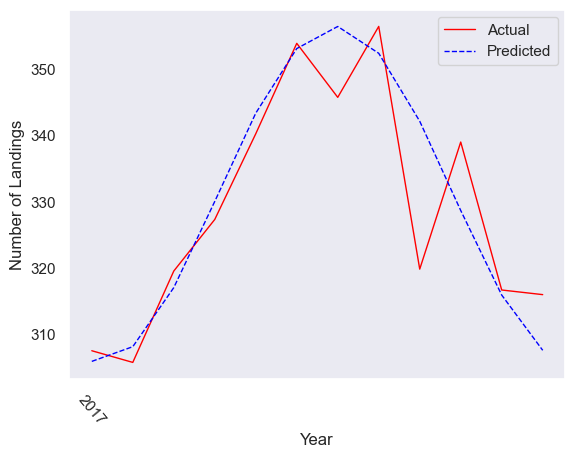

In [18]:
param, covariance = curve_fit(variable_sinusoid, features, y, p0=variable_get_p0(X,y))
plt.xticks(x_ticks, x_labels, rotation=310)
plt.ylabel("Number of Landings")
plt.xlabel("Year")
plt.plot(X, y, color="red", linewidth=1, label = 'Actual')
plt.plot(X, variable_sinusoid(features, *param), color="blue", linestyle="dashed", linewidth=1, label='Predicted')
plt.legend()
plt.show()

### Using the sinusoidal approximation model from above, I tried to predict future data. I used linear regression for the minimums and maximums of each wave. I also used a variable  𝑦𝑟_𝑡𝑜_𝑝𝑟𝑒𝑑𝑖𝑐𝑡_𝑡𝑜 so that we can choose what year we want the visualizations to go up to.

In [19]:
# reshape x_peaks
x_min_peaks = list(map(lambda l:[l], min_peaks[0])) 
x_max_peaks = list(map(lambda l:[l], max_peaks[0]))
# min model
model_min = linear_model.LinearRegression()
model_min.fit(x_min_peaks,min_peaks[1])
# max model
model_max = linear_model.LinearRegression()
model_max.fit(x_max_peaks,max_peaks[1])


yr_to_predict_to = 2025


yrs_into_future = yr_to_predict_to - 2018
for i in range(1, yrs_into_future + 1):
    x_min_peaks.append([x_min_peaks[len(x_min_peaks) -1][0] + T])
    x_max_peaks.append([x_max_peaks[len(x_max_peaks) -1][0] + T])
y_pred_min = model_min.predict(x_min_peaks)
y_pred_max = model_max.predict(x_max_peaks)

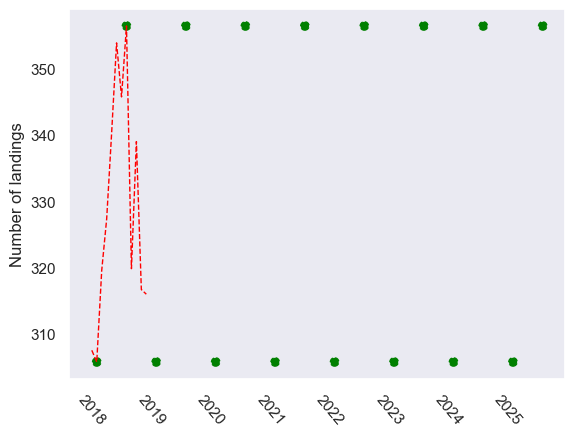

In [20]:
x_ticks_future = np.arange(0, len(X)+yrs_into_future*12, step=12)
x_labels_future = np.arange(2018, yr_to_predict_to + 1)

plt.xticks(x_ticks_future, x_labels_future, rotation=310)
plt.plot(X, y, color="red", linewidth=1,linestyle="dashed")
plt.scatter(x_min_peaks, y_pred_min, color="green", linewidth=1,linestyle="dashed")
plt.scatter(x_max_peaks, y_pred_max, color="green", linewidth=1,linestyle="dashed")
plt.ylabel("Number of landings")
plt.show()

#### Next, I used the linear regression model to plot the expected arrivals in sinusoidal form.

In [21]:
X_pred = np.arange(0, len(X) + T * yrs_into_future)
A_pred = A.copy()
offset_pred = offset.copy()
for i in range(yrs_into_future):
    index = len(max_peaks[1]) + i
    c_a = (y_pred_max[index] - y_pred_min[index])/2
    c_offset = y_pred_min[index] + c_a
    for j in range(0,T):
        A_pred.append(c_a)
        offset_pred.append(c_offset)
    features_pred = [X_pred,A_pred,offset_pred]

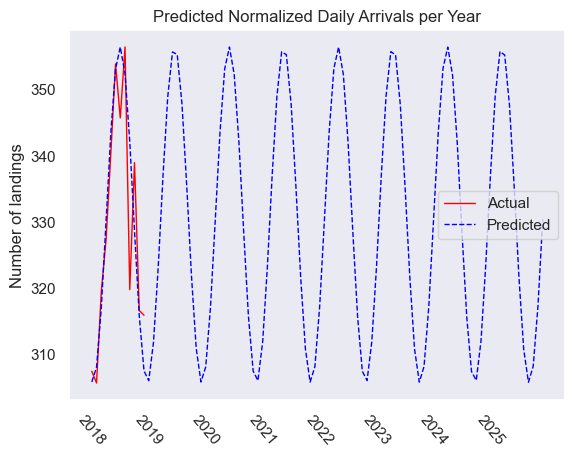

In [22]:
plt.xticks(x_ticks_future, x_labels_future, rotation=310)
plt.plot(X, y, color="red", linewidth=1, label = 'Actual')
plt.plot(X_pred, variable_sinusoid(features_pred, *param), color="blue", linewidth=1, linestyle='dashed', label="Predicted")
plt.ylabel("Number of landings")
plt.title("Predicted Normalized Daily Arrivals per Year")
plt.legend()
plt.show()

### Because this dataset did not have the aircraft types, I had to do some research on the most common ones. The closest thing I could find was the Oakland International Airport Master Plan (Chapter 3) from 2004. This is a forecast for 2010:
<img src="extra/aircraft_breakdowns_oak.png" style="width:400px;height:400px;">
<caption><center> Figure 1 : Breakdown of different aircraft types</center></caption><br>

In [23]:
idle_time = 26 * 60
to_time = 0.7 * 60
engines = pd.read_excel("edb-emissions-databank_v29 (web).xlsx", 'Gaseous Emissions and Smoke')
engines = engines[["Engine Identification", "Fuel Flow Idle (kg/sec)", "Fuel Flow T/O (kg/sec)"]]
engines['Idle Fuel (kg)'] = idle_time * engines['Fuel Flow Idle (kg/sec)']
engines['T/O Fuel (kg)'] = to_time * engines['Fuel Flow Idle (kg/sec)']
engines['Fuel Used (kg)'] = engines['T/O Fuel (kg)'] + engines['Idle Fuel (kg)']
engines = engines.drop(columns=["Fuel Flow Idle (kg/sec)", "Fuel Flow T/O (kg/sec)", 'Idle Fuel (kg)', 'T/O Fuel (kg)'])
engines.head()

,Engine Identification,Fuel Used (kg)
0,TFE731-2-2B,38.4480
1,TFE731-3,41.6520
2,AE3007A,78.4980
3,AE3007C1,67.2840
4,AE3007A1,73.8522


In [24]:
passenger_eng_id = ['CFM56-5B4', 'JT8D-15', 'PW2037', 'CF6-80C2B1F', 'PW1124G1-JM']
passenger_percentages = [11.1, 81.2, 1.5, 0.4, 5.9]
cargo_eng_id = ['CF6-80A1', 'CF6-80C2A1', 'CF6-80C2B2F', 'CF6-80C2B1F', 'JT8D-11', 'CF6-6D', 'GE CF6-80C2A3', 'Trent 556-61', 
                'small jet', 'small single engine', 'small turbopop', 'small twin engine']
cargo_percentages = [6.1, 14.6, 8.5, 1.2, 3.7, 4.9, 12.2, 1.2, 2.4, 4.9, 22.0, 18.3]

### NOTE: The Engine Identification dataset did not have data on the following: small jet, small single engine, small turbopop, small twin engine. Combining their percentages, they make up almost half of the cargo landings per day. We could fill their values with the averages of the others, but this could also lead to a large margin of error.

### Next, we must take into consideration the percentages of passenger planes and cargo planes.

In [25]:
ratio = 542 / (542 + 164)
passenger_percentages = [i * ratio for i in passenger_percentages]
cargo_percentages = [i * (1 - ratio) for i in cargo_percentages]
#should be ~100%
sum(passenger_percentages) + sum(cargo_percentages)

100.07677053824362

In [26]:
passenger_data = {'Engine Identification': passenger_eng_id,
        'Percentages': passenger_percentages}
passenger_perc = pd.DataFrame(passenger_data)
passenger_perc

,Engine Identification,Percentages
0,CFM56-5B4,8.521530
1,JT8D-15,62.337677
2,PW2037,1.151558
3,CF6-80C2B1F,0.307082
4,PW1124G1-JM,4.529462


In [27]:
cargo_data = {'Engine Identification': cargo_eng_id,
             'Percentages': cargo_percentages}
cargo_perc = pd.DataFrame(cargo_data)
cargo_perc

,Engine Identification,Percentages
0,CF6-80A1,1.416997
1,CF6-80C2A1,3.391501
2,CF6-80C2B2F,1.974504
3,CF6-80C2B1F,0.278754
4,JT8D-11,0.859490
5,CF6-6D,1.138244
6,GE CF6-80C2A3,2.833994
7,Trent 556-61,0.278754
8,small jet,0.557507
9,small single engine,1.138244


In [28]:
0.557507 + 1.138244 + 5.110482 + 4.250992

11.057225

#### When factoring in this ratio, we see that the unknown engine types only make up for about 11% of the total landings. Therefore, it does not actually create too large of an error margin to assume the average of the other cargo engines.

### Next, I began merging the datasets together.

In [29]:
# ensure each Engine Identification maps to one Fuel LTO Cycle (kg)
engines = engines.groupby('Engine Identification').mean().reset_index()
engines.head()

,Engine Identification,Fuel Used (kg)
0,AE3007A,78.4980
1,AE3007A1,73.8522
2,AE3007A1 series,80.1000
3,AE3007A1/1,73.5318
4,AE3007A1/3,71.9298


#### Filling the NaN values with the mean of the cargo planes:

In [30]:
cargo_perc = cargo_perc.merge(engines, how='left', on='Engine Identification')
ratio2 = 198 / 5000
fill_mean_val = cargo_perc['Fuel Used (kg)'].mean() * ratio2
cargo_perc['Fuel Used (kg)'] = cargo_perc['Fuel Used (kg)'].fillna(fill_mean_val)
cargo_perc

,Engine Identification,Percentages,Fuel Used (kg)
0,CF6-80A1,1.416997,240.30000
1,CF6-80C2A1,3.391501,320.40000
2,CF6-80C2B2F,1.974504,298.93320
3,CF6-80C2B1F,0.278754,321.20100
4,JT8D-11,0.859490,233.09100
5,CF6-6D,1.138244,276.82560
6,GE CF6-80C2A3,2.833994,11.64925
7,Trent 556-61,0.278754,368.46000
8,small jet,0.557507,11.64925
9,small single engine,1.138244,11.64925


In [31]:
passenger_perc = passenger_perc.merge(engines, how='left', on='Engine Identification')
passenger_perc

,Engine Identification,Percentages,Fuel Used (kg)
0,CFM56-5B4,8.521530,171.4140
1,JT8D-15,62.337677,236.6154
2,PW2037,1.151558,234.6930
3,CF6-80C2B1F,0.307082,321.2010
4,PW1124G1-JM,4.529462,128.1600


In [32]:
frames = [passenger_perc, cargo_perc]
models = pd.concat(frames).reset_index(drop=True)
models

,Engine Identification,Percentages,Fuel Used (kg)
0,CFM56-5B4,8.521530,171.41400
1,JT8D-15,62.337677,236.61540
2,PW2037,1.151558,234.69300
3,CF6-80C2B1F,0.307082,321.20100
4,PW1124G1-JM,4.529462,128.16000
5,CF6-80A1,1.416997,240.30000
6,CF6-80C2A1,3.391501,320.40000
7,CF6-80C2B2F,1.974504,298.93320
8,CF6-80C2B1F,0.278754,321.20100
9,JT8D-11,0.859490,233.09100


In [33]:
# account for twin engines
if (models['Fuel Used (kg)'][0] == 171.41400):
    models['Fuel Used (kg)'] *= 2
models

,Engine Identification,Percentages,Fuel Used (kg)
0,CFM56-5B4,8.521530,342.828000
1,JT8D-15,62.337677,473.230800
2,PW2037,1.151558,469.386000
3,CF6-80C2B1F,0.307082,642.402000
4,PW1124G1-JM,4.529462,256.320000
5,CF6-80A1,1.416997,480.600000
6,CF6-80C2A1,3.391501,640.800000
7,CF6-80C2B2F,1.974504,597.866400
8,CF6-80C2B1F,0.278754,642.402000
9,JT8D-11,0.859490,466.182000


### Week 7 Wrap Up
This week, I built a function that used different start years so that we could best identify which year produces the optimal output. I also hardcoded the engine types and began merging the datasets to match the Oakland International Airport Master Plan.

## Week 8

### This week, I fixed the issues from the previous week by averaging each month's landings in 2017, 2018, and 2019. Using this average, I proceeded with the sinusoidal regression model. I also made some changes to last week's work where I had used the entirety of the LTO Cycle instead of only the two stages that we are focusing on in this study.

In [34]:
fuel_used_per_landing = sum((models['Percentages']/100) * models['Fuel Used (kg)'])
fuel_used_per_landing

400.94091724276524

In [35]:
avg_lst = {'Month': np.arange(1, 13),
        'Landings Per Day': y}
monthly_final = pd.DataFrame(avg_lst)
monthly_final['Fuel Per Day (kg/day)'] = monthly_final['Landings Per Day'] * fuel_used_per_landing
monthly_final

,Month,Landings Per Day,Fuel Per Day (kg/day)
0,1,307.505376,123291.487648
1,2,305.743460,122585.063260
2,3,319.526882,128111.401041
3,4,327.311111,131232.417113
4,5,340.236559,136414.758101
5,6,353.877778,141884.080814
6,7,345.731183,138617.777550
7,8,356.433333,142908.707603
8,9,319.817204,128227.803242
9,10,338.989247,135914.659753


#### From here, I updated the regression model trained on the fuel usage:

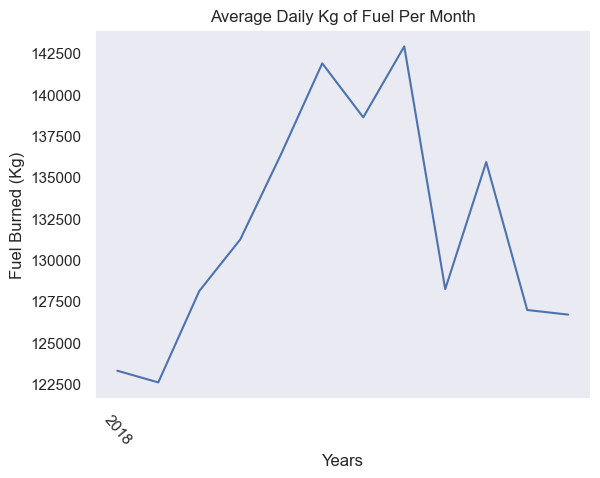

In [36]:
X2 = np.arange(0, len(monthly_final))
y2 = monthly_final['Fuel Per Day (kg/day)'].tolist()
plt.plot(X2, y2)
x_ticks = np.arange(0, len(X2), step=12)
x_labels = np.arange(2018, 2019)
plt.xticks(x_ticks, x_labels, rotation=310)
plt.title("Average Daily Kg of Fuel Per Month")
plt.xlabel("Years")
plt.ylabel("Fuel Burned (Kg)")
plt.show()

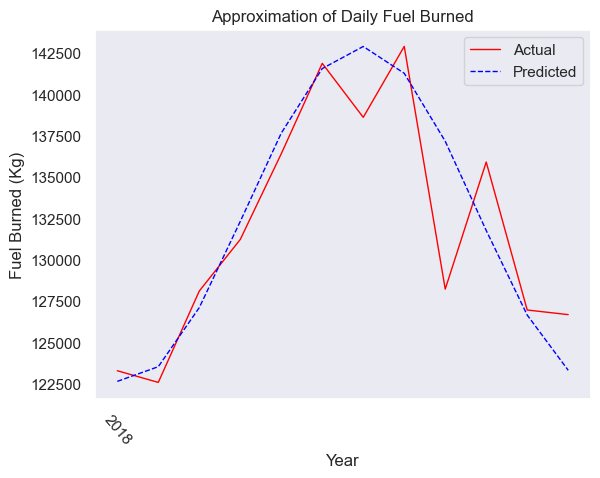

In [37]:
min_peaks2 = get_peaks(y2,min)
max_peaks2 = get_peaks(y2,max)
A2 = []
offset2 = []
for i in range(0, len(min_peaks2[1])):
    c_a = (max_peaks2[1][i] - min_peaks2[1][i])/2
    c_offset = min_peaks2[1][i] + c_a
    for j in range(0,T):
        A2.append(c_a)
        offset2.append(c_offset)
features2 = [X2, A2, offset2]

param, covariance = curve_fit(variable_sinusoid, features2, y2, p0=variable_get_p0(X2,y2))
plt.xticks(x_ticks, x_labels, rotation=310)
plt.title("Approximation of Daily Fuel Burned")
plt.ylabel("Fuel Burned (Kg)")
plt.xlabel("Year")
plt.plot(X2, y2, color="red", linewidth=1, label = 'Actual')
plt.plot(X2, variable_sinusoid(features2, *param), color="blue", linestyle="dashed", linewidth=1, label='Predicted')
plt.legend()
plt.show()

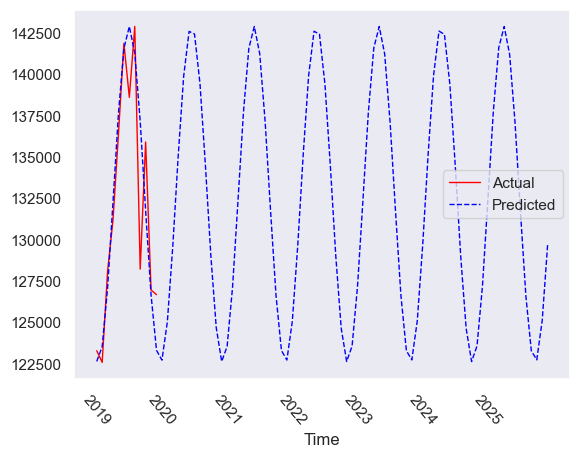

In [44]:
# reshape x_peaks
x_min_peaks2 = list(map(lambda l:[l], min_peaks2[0])) 
x_max_peaks2 = list(map(lambda l:[l], max_peaks2[0]))
# min model
model_min2 = linear_model.LinearRegression()
model_min2.fit(x_min_peaks2,min_peaks2[1])
# max model
model_max2 = linear_model.LinearRegression()
model_max2.fit(x_max_peaks2,max_peaks2[1])


yr_to_predict_to = 2025


yrs_into_future = yr_to_predict_to - 2019
for i in range(1, yrs_into_future + 1):
    x_min_peaks2.append([x_min_peaks2[len(x_min_peaks2) -1][0] + T])
    x_max_peaks2.append([x_max_peaks2[len(x_max_peaks2) -1][0] + T])
y_pred_min2 = model_min2.predict(x_min_peaks2)
y_pred_max2 = model_max2.predict(x_max_peaks2)

x_ticks_future = np.arange(0, len(X2)+yrs_into_future*12, step=12)
x_labels_future = np.arange(2019, yr_to_predict_to + 1)

X_pred2 = np.arange(0, len(X2) + T * yrs_into_future)
A_pred2 = A2.copy()
offset_pred2 = offset2.copy()
for i in range(yrs_into_future):
    index = len(max_peaks2[1]) + i
    c_a = (y_pred_max2[index] - y_pred_min2[index])/2
    c_offset = y_pred_min2[index] + c_a
    for j in range(0,T):
        A_pred2.append(c_a)
        offset_pred2.append(c_offset)
    features_pred2 = [X_pred2,A_pred2,offset_pred2]

plt.xticks(x_ticks_future, x_labels_future, rotation=310)
plt.plot(X2, y2, color="red", linewidth=1, label = 'Actual')
plt.plot(X_pred2, variable_sinusoid(features_pred2, *param), color="blue", linewidth=1, linestyle='dashed', label="Predicted")
# plt.ylabel("Fuel Burned (Kg)")
# plt.title("Predicted Normalized Daily Fuel Burned per Month of the Year")
plt.xlabel('Time')
plt.legend()
plt.show()


### The final $CO_2$ emissions function!

In [39]:
def expected_CO2_emissions(month, year):
    assert year <= yr_to_predict_to, "Year " + year + " out of range."
    conversion = (year - 2019) * 12 + month
    const = 3.16
    kg_of_co2 = (int) (np.round(3.16 * (variable_sinusoid(features_pred2, *param)[conversion])))
    tonnes_of_co2 = (int) (np.round(kg_of_co2 / 1000))
    return "In " + str(month) + "/" + str(year) + ", there will be " + str(kg_of_co2) + " kg, or " + str(tonnes_of_co2) + " tonnes of CO2 released per day from OAK."


In [40]:
expected_CO2_emissions(3, 2023)

'In 3/2023, there will be 447471 kg, or 447 tonnes of CO2 released per day from OAK.'

## Wrap Up
Using similar methods to those used in SFO, I used sinusoidal regression on the daily average landings between 2017-2019 to create a function that takes in a month and a year and outputs the amount of $CO_2$ released per day.